In [2]:
from IPython.display import clear_output

! pip install torch torchvision ftfy regex tqdm scikit-learn simhash pillow imagehash transformers pandas numpy matplotlib
! pip install git+https://github.com/openai/CLIP.git

clear_output()

## project paths

In [ ]:
import sys
import os
import json
from pathlib import Path

CWD = Path.cwd()
PROJECT_ROOT = CWD if (CWD / "src").exists() else CWD.parent

SRC_DIR = PROJECT_ROOT / "src"
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("CWD:", CWD)
print("PROJECT_ROOT:", PROJECT_ROOT)

def find_first_existing(*candidates: Path) -> Path:
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError("None of these paths exist:\n" + "\n".join(str(c) for c in candidates))


TWEETS_PATH = find_first_existing(
    PROJECT_ROOT / "health_tweets_labeled.json",
    PROJECT_ROOT / "data" / "health_tweets_labeled.json",
    PROJECT_ROOT / "outputs" / "health_tweets_labeled.json",
    SRC_DIR / "health_tweets_labeled.json",
)

print("Using TWEETS_PATH:", TWEETS_PATH)


CWD: /Users/farah/arabic-health-twitter-pipeline/src
PROJECT_ROOT: /Users/farah/arabic-health-twitter-pipeline
Using TWEETS_PATH: /Users/farah/arabic-health-twitter-pipeline/health_tweets_labeled.json


## Expand per image

In [5]:
import pandas as pd

df = pd.DataFrame(json.loads(TWEETS_PATH.read_text(encoding="utf-8")))

df = df[df["label"].fillna("") != "unverified"].copy()

if "image_local_paths" in df.columns:
    img_col = "image_local_paths"
elif "image_paths" in df.columns:
    img_col = "image_paths"
else:
    raise ValueError("No image paths column found. Expected 'image_local_paths' or 'image_paths'.")

def ensure_list(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str) and x.strip():
        return [x.strip()]
    return []

df[img_col] = df[img_col].apply(ensure_list)

# Explode
img_df = df.explode(img_col).rename(columns={img_col: "image_path"}).reset_index(drop=True)
img_df = img_df[img_df["image_path"].notna()].copy()

def resolve_to_file(p):
    p = str(p)
    # 1) already absolute / direct
    cand = Path(p)
    if cand.is_file():
        return cand

    # 2) relative to PROJECT_ROOT
    cand = PROJECT_ROOT / p
    if cand.is_file():
        return cand

    # 3) relative to src/
    cand = SRC_DIR / p
    if cand.is_file():
        return cand

    # 4) common folder names
    for folder in ["tweet_images", "images", "data", "outputs"]:
        cand = PROJECT_ROOT / folder / p
        if cand.is_file():
            return cand

    return None

img_df["image_file"] = img_df["image_path"].apply(resolve_to_file)
img_df = img_df[img_df["image_file"].notna()].copy()
img_df["image_file"] = img_df["image_file"].astype(str)

print("Rows after explode+resolve:", img_df.shape)
img_df[["tweet_id", "label", "image_path", "image_file"]].head()


Rows after explode+resolve: (543, 17)


,tweet_id,label,image_path,image_file
0,1995839467203297706,true,tweet_images/1995839467203297706_0.jpg,/Users/farah/arabic-health-twitter-pipeline/tw...
1,1995838664849662027,true,tweet_images/1995838664849662027_0.jpg,/Users/farah/arabic-health-twitter-pipeline/tw...
2,1995838359407624641,true,tweet_images/1995838359407624641_0.jpg,/Users/farah/arabic-health-twitter-pipeline/tw...
3,1995838167014862916,misleading,tweet_images/1995838167014862916_0.jpg,/Users/farah/arabic-health-twitter-pipeline/tw...
4,1995837929135243743,true,tweet_images/1995837929135243743_0.jpg,/Users/farah/arabic-health-twitter-pipeline/tw...


## Encode image and text functions

In [6]:
import torch
import clip
from PIL import Image
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

def clip_safe_text(text: str, max_chars: int = 250) -> str:
    t = (text or "").strip()
    return t[:max_chars] if len(t) > max_chars else t

@torch.no_grad()
def encode_image_and_text(img_file: str, text: str):
    image = Image.open(img_file).convert("RGB")
    image_input = preprocess(image).unsqueeze(0).to(device)

    # CLIP max tokens = 77; tokenize handles it
    safe_txt = clip_safe_text(text)
    text_tokens = clip.tokenize([safe_txt], truncate=True).to(device)

    # encode
    image_features = model.encode_image(image_input)
    text_features  = model.encode_text(text_tokens)

    # normalize
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features  = text_features  / text_features.norm(dim=-1, keepdim=True)

    return image_features[0].cpu().numpy().astype("float32"), text_features[0].cpu().numpy().astype("float32")

100%|███████████████████████████████████████| 338M/338M [01:32<00:00, 3.83MiB/s]


In [8]:
print(df.columns)
print("Labels:", df["label"].value_counts())
print("Image rows:", len(img_df))
print("Example image file:", img_df["image_file"].iloc[0])

Index(['tweet_id', 'author_id', 'author_screen_name', 'text', 'created_at',
       'lang', 'image_urls', 'raw', 'ocr_texts', 'ocr_text_combined',
       'has_claim_pattern', 'label', 'label_justification', 'label_sources',
       'image_paths', 'is_strong_claim'],
      dtype='object')
Labels: label
true          342
misleading     43
false          19
Name: count, dtype: int64
Image rows: 543
Example image file: /Users/farah/arabic-health-twitter-pipeline/tweet_images/1995839467203297706_0.jpg


## combined text field (CLIP + AraBERT input)

In [9]:
def combine_text(row):
    t = row.get("text") or ""
    o = row.get("ocr_text_combined") or ""
    return (t + " " + o).strip()

img_df["combined_text"] = img_df.apply(combine_text, axis=1)

img_df[["combined_text"]].head()

,combined_text
0,🚫🚫🚫\nقبل ما تمد يدك على أي علبة فوق الرف… شيّك...
1,في الجلسة الحوارية لنمط الحياة الصحي، قالت د. ...
2,متى يُصبح الخلع ضرورة وليس خياراً؟\n\nعندما يت...
3,مسحوق كيان (الفلفل الاحمر والليمون)\n\n✨غني با...
4,محاضرة توعوية تعنى بالابتزاز الإلكتروني، قدّمه...


## Encode images with CLIP

In [10]:
from tqdm import tqdm
import numpy as np

image_embeds = []
labels = []

label_map = {"false": 0, "misleading": 1, "true": 2}

for _, row in tqdm(img_df.iterrows(), total=len(img_df)):
    try:
        img_vec, _ = encode_image_and_text(
            row["image_file"],
            row["combined_text"]
        )
        image_embeds.append(img_vec)
        labels.append(label_map[row["label"]])
    except Exception as e:
        print("Skipping image:", row["image_file"], "|", e)

image_embeds = np.stack(image_embeds)
labels = np.array(labels)

image_embeds.shape, labels.shape


100%|██████████| 543/543 [00:30<00:00, 17.87it/s]


((543, 512), (543,))

## Encode text with AraBERT

In [11]:
from transformers import AutoTokenizer, AutoModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

arabert_name = "aubmindlab/bert-base-arabertv2"
tokenizer = AutoTokenizer.from_pretrained(arabert_name)
arabert = AutoModel.from_pretrained(arabert_name).to(device)
arabert.eval()

@torch.no_grad()
def encode_arabert(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    ).to(device)

    outputs = arabert(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.squeeze(0).cpu().numpy()


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [12]:
text_embeds = []

for text in tqdm(img_df["combined_text"]):
    try:
        vec = encode_arabert(text)
        text_embeds.append(vec)
    except Exception as e:
        print("Text encoding error:", e)

text_embeds = np.stack(text_embeds)

text_embeds.shape


100%|██████████| 543/543 [00:22<00:00, 24.36it/s]


(543, 768)

## Multimodal fusion

In [13]:
X = np.concatenate([image_embeds, text_embeds], axis=1)
y = labels

X.shape, y.shape

((543, 1280), (543,))

## Stratified train/test split

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

## classifier (scaled data)

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

clf = LogisticRegression(
    max_iter=2000
)

clf.fit(X_train_s, y_train)

LogisticRegression(max_iter=2000)

## Evaluation

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ["false", "misleading", "true"]

y_pred = clf.predict(X_test_s)

print(classification_report(
    y_test,
    y_pred,
    target_names=target_names,
    digits=3,
    zero_division=0,
))

              precision    recall  f1-score   support

       false      0.750     0.375     0.500         8
  misleading      0.600     0.400     0.480        15
        true      0.906     0.964     0.934       140

    accuracy                          0.883       163
   macro avg      0.752     0.580     0.638       163
weighted avg      0.870     0.883     0.871       163



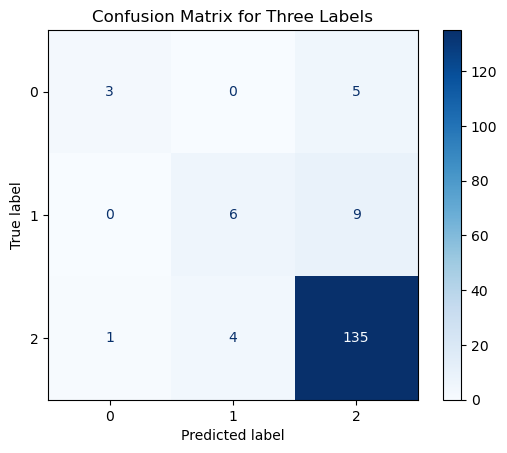

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Three Labels')
plt.show()

## Save artifacts for reproducibility

In [32]:
np.save("X_features.npy", X)
np.save("y_labels.npy", y)